실험 데이터 예시 (재료 조합):
[[3 6]
 [7 2]
 [0 3]
 [1 7]
 [3 1]]

실험 데이터 예시 (관측된 성능):
[-0.1719328   0.87167102  0.57682861  0.63737082  0.66704196]


Initializing NUTS using jitter+adapt_diag...
/home/lsw91/Workspace/pymc-gp/.venv/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [embeddings, ell, eta, f_rotated_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 564 seconds.
There were 1323 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



--- 학습 완료 후 ---
학습된 임베딩 테이블의 평균값 (shape: (10, 3)):
<xarray.DataArray 'embeddings' (embeddings_dim_0: 10, embeddings_dim_1: 3)> Size: 240B
array([[-0.00696643, -0.06543976, -0.03380428],
       [ 0.08688678,  0.14851685, -0.11286215],
       [-0.05297599,  0.17731398, -0.06395594],
       [-0.06553173, -0.22442132, -0.00353447],
       [ 0.07317913,  0.14664112,  0.1110402 ],
       [-0.08312031, -0.10307023,  0.13826066],
       [ 0.01435856, -0.11143428,  0.08151588],
       [-0.01267325, -0.09088508,  0.10064136],
       [ 0.01855398, -0.10777042,  0.07874668],
       [-0.07646739, -0.0504969 ,  0.1011445 ]])
Coordinates:
  * embeddings_dim_0  (embeddings_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9
  * embeddings_dim_1  (embeddings_dim_1) int64 24B 0 1 2


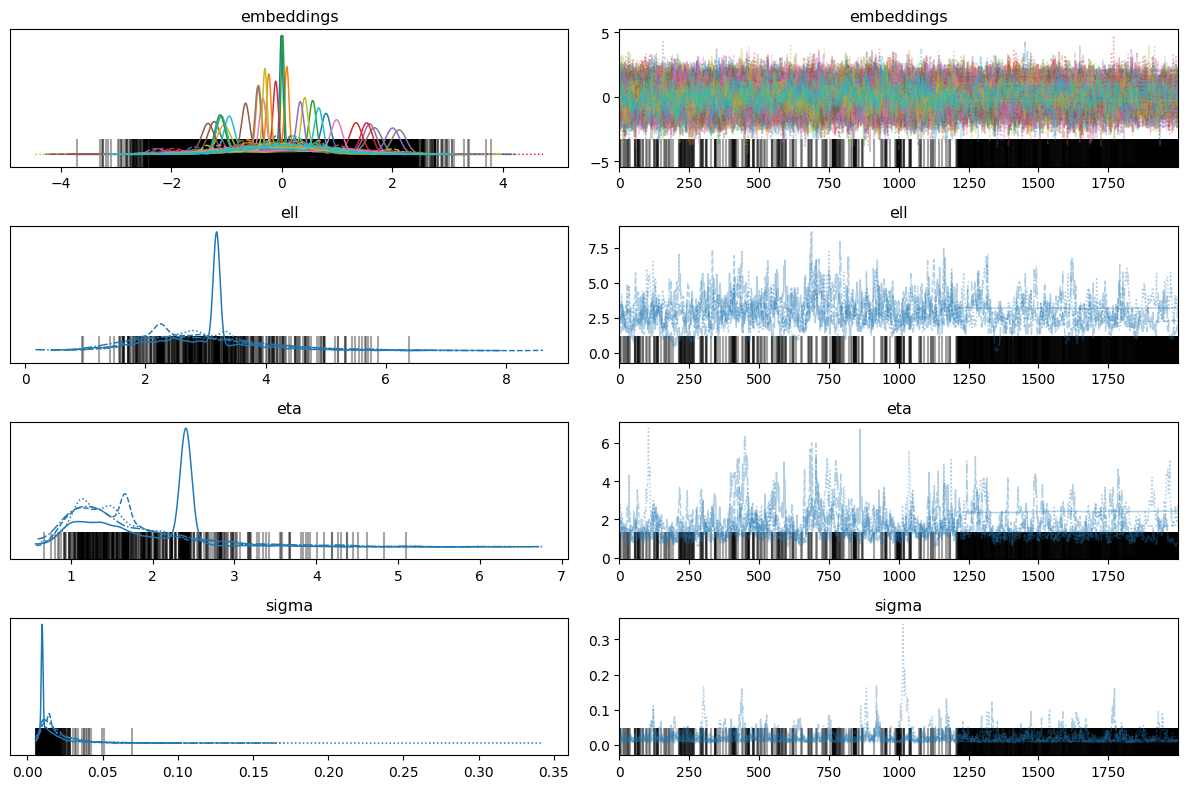

In [2]:
import pymc as pm
import numpy as np
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt

# 1. 가상 데이터 생성
# 10개의 원재료, 3차원 임베딩 공간으로 가정
N_MATERIALS = 10
EMBEDDING_DIM = 3

# 실제로는 이 true_embeddings 값을 모르는 상태에서 시작합니다.
np.random.seed(42)
true_embeddings = np.random.randn(N_MATERIALS, EMBEDDING_DIM)
true_gp_lengthscale = 1.5

# 20개의 실험 조합 (2개씩 조합)
N_SAMPLES = 20
material_combos = np.random.randint(0, N_MATERIALS, size=(N_SAMPLES, 2))

# 조합의 성능 계산 (임베딩 합 + 약간의 비선형성 + 노이즈)
# 실제 문제에서는 이 성능(y)만 관측된 데이터입니다.
combo_vectors = true_embeddings[material_combos[:, 0]] + true_embeddings[material_combos[:, 1]]
y = np.sin(combo_vectors[:, 0]) * 5 + combo_vectors[:, 1]**2 + np.random.randn(N_SAMPLES) * 0.1
y = (y - y.mean()) / y.std() # 표준화

print("실험 데이터 예시 (재료 조합):")
print(material_combos[:5])
print("\n실험 데이터 예시 (관측된 성능):")
print(y[:5])


# 2. PyMC 모델 정의
with pm.Model() as model:
    # --- 핵심 부분: 임베딩 테이블 학습 ---
    # 각 재료의 임베딩 벡터를 표준정규분포를 따르는 '사전 분포(prior)'로 설정합니다.
    # 이 `embeddings` 변수가 바로 우리가 학습시키려는 대상입니다.
    embeddings = pm.Normal('embeddings', mu=0, sigma=1, shape=(N_MATERIALS, EMBEDDING_DIM))

    # 데이터로 주어진 재료 조합(material_combos)을 이용해
    # 각 조합에 해당하는 임베딩 벡터들을 더합니다.
    # 이것이 GP 모델의 입력(X)이 됩니다.
    X = embeddings[material_combos[:, 0]] + embeddings[material_combos[:, 1]]

    # --- GP 모델 부분 ---
    # GP의 길이척도(lengthscale)에 대한 사전 분포 설정
    ell = pm.Gamma('ell', alpha=2, beta=1)
    # GP의 분산에 대한 사전 분포 설정
    eta = pm.HalfCauchy('eta', beta=5)

    # 커널 함수 정의 (RBF 커널)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=EMBEDDING_DIM, ls=ell)
    gp = pm.gp.Latent(cov_func=cov)

    # 잠재 GP(f)를 X에 대해 정의
    f = gp.prior('f', X=X)

    # --- 데이터와 모델 연결 (Likelihood) ---
    # 관측 노이즈에 대한 사전 분포
    sigma = pm.HalfCauchy('sigma', beta=5)
    # y는 잠재 함수 f와 관측 노이즈 sigma를 따를 것이라고 정의
    Y_obs = pm.Normal('Y_obs', mu=f, sigma=sigma, observed=y)


# 3. 베이지안 추론 실행 (MCMC)
with model:
    # NUTS 샘플러를 이용해 파라미터들의 사후 분포를 샘플링합니다.
    # 이 과정에서 'embeddings'의 값들도 데이터에 맞게 최적화됩니다.
    trace = pm.sample(2000, tune=1000, chains=4, core_count=4, target_accept=0.9)


# 4. 결과 확인
# 학습된 임베딩 테이블의 평균값을 확인합니다.
# trace.posterior['embeddings']는 (chains, draws, N_MATERIALS, EMBEDDING_DIM) 형태
learned_embeddings_mean = trace.posterior['embeddings'].mean(axis=(0, 1))

print("\n--- 학습 완료 후 ---")
print("학습된 임베딩 테이블의 평균값 (shape: {}):".format(learned_embeddings_mean.shape))
print(learned_embeddings_mean)

# ArviZ를 사용한 시각화
az.plot_trace(trace, var_names=['embeddings', 'ell', 'eta', 'sigma'])
plt.tight_layout()
plt.show()
